
# 🧪 Bayesian modelling of kinetic data with latent Gaussian processes

In this exercise, you will analyze simulated enzyme kinetic data where the reaction rate constant `k` depends on process conditions: **temperature (T)** and **pH**.

The aim is to:
- Simulate and explore the kinetics data
- Prepare the data for modeling
- Define and fit a **Gaussian process (GP)** model using **PyMC**
- Interpret the posterior of the latent function `k(T, pH)`

You will use a latent GP prior to model how `k` varies across experimental conditions.


In [ ]:
# Install PyMC if not already installed
!pip install pymc --quiet

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor


pytensor.config.cxx = "/usr/bin/clang++"


## 📈 Step 1: Visualize exemplery reaction curves

Before modelling, let's build some intuition.

**Task:** Plot 4–5 product curves (`P_obs` vs `Time`) for different combinations of `T` and `pH`. What trends do you observe?


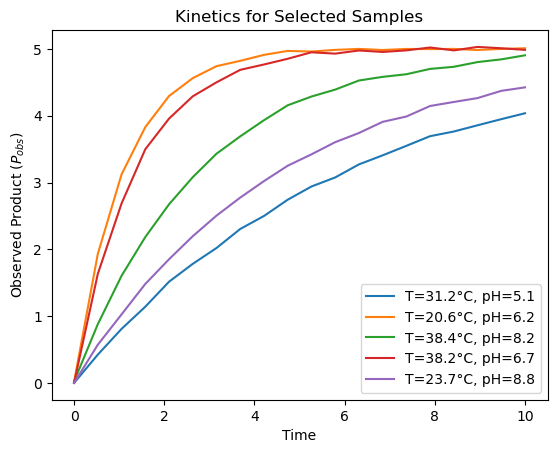

In [4]:
kinetic_data = pd.read_csv("kinetic_data.csv")

# TODO: Select a few SampleIDs and plot P_obs over time
sample_ids_to_plot = [0, 10, 20, 30, 40]

for sid in sample_ids_to_plot:
    subset = kinetic_data[kinetic_data["SampleID"] == sid]
    label = f"T={subset['T'].iloc[0]:.1f}°C, pH={subset['pH'].iloc[0]:.1f}"
    plt.plot(subset["Time"], subset["P_obs"], label=label)

plt.xlabel("Time")
plt.ylabel("Observed Product ($P_{obs}$)")
plt.legend()
plt.title("Kinetics for Selected Samples")
plt.show()



## 🛠️ Exercise 2: Reshape Data for Modeling

PyMC needs a 2D matrix of observations: rows = samples, columns = time points.

**Tasks:**
1. Load the CSV file.
2. Standardize `T` and `pH` (z-score).
3. Reshape `P_obs` into a matrix (`samples x time_points`).


In [5]:
data = pd.read_csv("kinetic_data.csv")
data["log_Time"] = np.log(data["Time"] + 1e-3)  # avoid log(0)

unique_samples = data[["SampleID", "T", "pH"]].drop_duplicates().reset_index(drop=True)
unique_times = np.sort(data["Time"].unique())
n_samples = len(unique_samples)
n_timepoints = len(unique_times)

# Map SampleID to index
sample_index = {sid: i for i, sid in enumerate(unique_samples["SampleID"])}
data["sample_idx"] = data["SampleID"].map(sample_index)

# TODO: Reshape P_obs to matrix [samples x time]
P_obs_matrix = np.full((n_samples, n_timepoints), np.nan)
for i, sid in enumerate(unique_samples["SampleID"]):
    subset = data[data["SampleID"] == sid].sort_values("Time")
    P_obs_matrix[i, :] = subset["P_obs"].values

# TODO: Standardize T and pH
T_std = (unique_samples["T"] - unique_samples["T"].mean()) / unique_samples["T"].std()
pH_std = (unique_samples["pH"] - unique_samples["pH"].mean()) / unique_samples["pH"].std()
X = np.vstack([T_std, pH_std]).T
X.shape


(100, 2)


## 🧠 Exercise 3: Define a GP Model in PyMC

We now define a latent Gaussian Process over `log(k)` as a function of (T, pH).

**Tasks:**
- Fill in the GP prior and likelihood.
- Use `ExpQuad` kernel with separate length scales for T and pH.


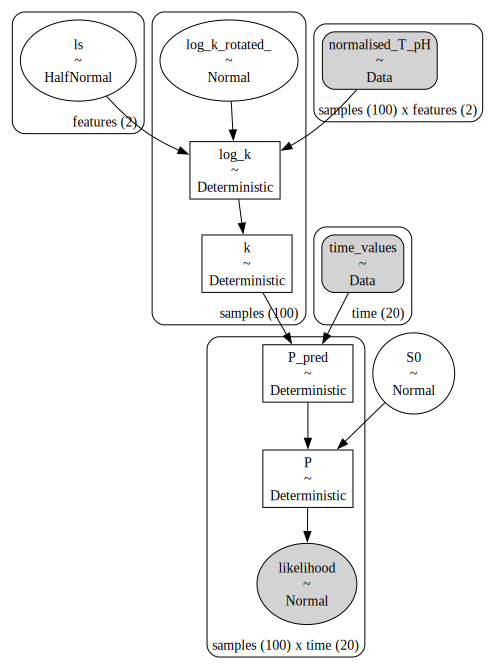

In [6]:
coords = {
    "samples": unique_samples["SampleID"].values,
    "time": unique_times,
    "features": ["T", "pH"],
}

with pm.Model(coords=coords) as model:
    # Priors
    ls = pm.HalfNormal("ls", sigma=1.0, dims="features")
    cov_func = pm.gp.cov.ExpQuad(input_dim=2, ls=ls)
    gp = pm.gp.Latent(mean_func=pm.gp.mean.Zero(), cov_func=cov_func)
    normalised_T_pH = pm.Data("normalised_T_pH", X, dims=("samples", "features"))

    # TODO: GP prior over log(k)
    log_k = gp.prior("log_k", X=normalised_T_pH, dims="samples")
    
    # TODO: Compute predicted P from k
    k = pm.Deterministic("k", pm.math.exp(log_k), dims="samples")
    tvals = pm.Data("time_values", unique_times, dims="time")
    pred = pm.Deterministic("P_pred", pm.math.exp(-k[:, None] * tvals[None, :]), dims=("samples", "time"))
    
    # The initial substrate concentration is usually known
    # We can add small noise to it to account for pipetting errors
    S_0 = pm.Normal("S0", mu=5, sigma=0.1)
    P = pm.Deterministic("P", S_0 * (1 - pred), dims=("samples", "time"))
    likelihood = pm.Normal("likelihood", mu=P, observed=P_obs_matrix, dims=("samples", "time"))

# Visualise the computatin graph of your model
model.to_graphviz()


In [ ]:
# Inference
with model:
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ls, log_k_rotated_, S0]


Output()

Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 109 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


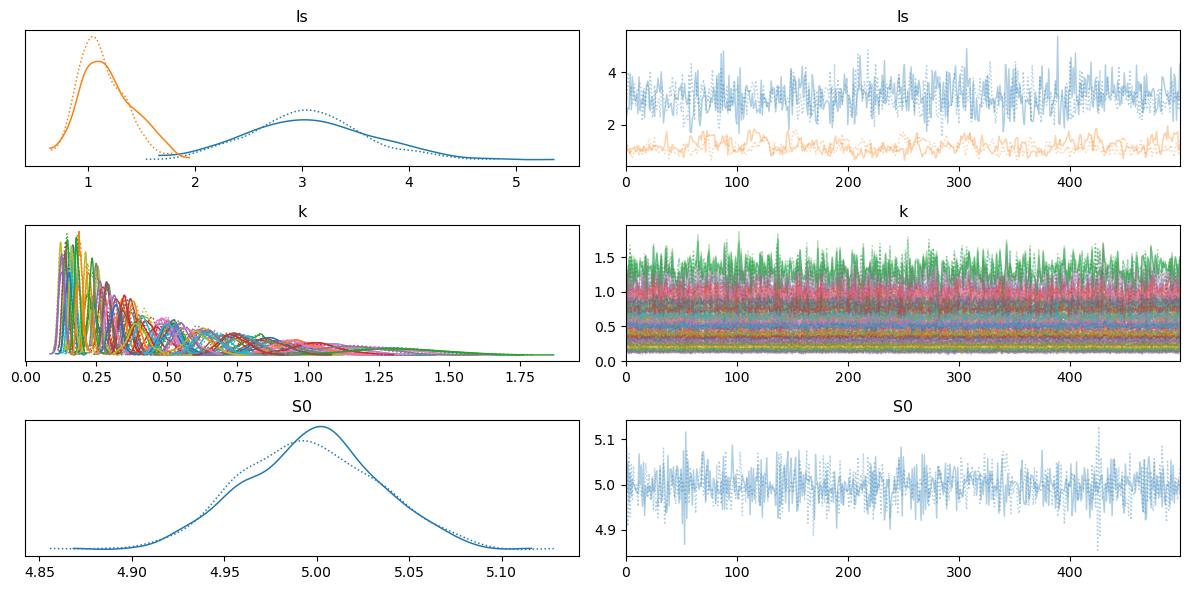

In [10]:
az.plot_trace(trace, var_names=["ls", "k", "S0"])
plt.tight_layout()
plt.show()


## 📊 Exercise 4: Posterior Visualization

**Task:** Plot the posterior mean of `k` across the (T, pH) conditions.

Optional: Plot samples from the posterior to visualize uncertainty.


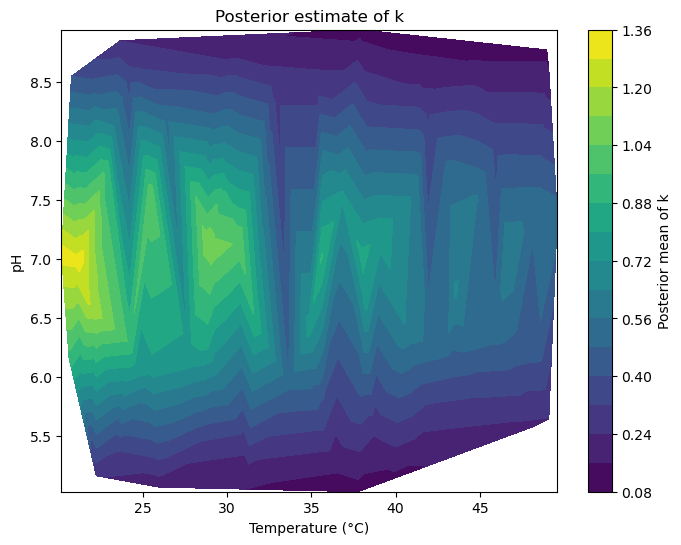

In [ ]:
pst = trace.posterior.stack(sample=("chain", "draw"))
k_samples = pst["k"].values  # shape: (samples, draws)
k_mean = k_samples.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.tricontourf(unique_samples["T"], unique_samples["pH"], k_mean, levels=14, cmap="viridis")
plt.colorbar(label="Posterior mean of k")
plt.xlabel("Temperature (°C)")
plt.ylabel("pH")
plt.title("Posterior estimate of k")
plt.show()



## 🧭 Bonus Questions

1. Why might we prefer a latent GP prior over a fixed parametric form?
2. What do the length scales tell you about sensitivity to T and pH?
3. Can you think of a way to incorporate replicate measurements?
4. Can you figure out the optimal conditions (T, pH)? How could you do that?
